### logspace rate

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. 动力学方程 (Strict LaTeX adherence)
# ==========================================
def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    """
    根据提供的 LaTeX 公式计算 dz/dt
    z: [z1, z2] (complex array)
    """
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    
    # 序参量 Z = q*z1 + p*z2
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    
    # 安全措施：防止分母为 0 (尽管在扫描中我们避开了 0 和 1)
    eps = 1e-12
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    # --- 严格对照 LaTeX ---
    # dot{z}_1 = -gamma*z1 - (K1/2)*Z*z1^2 + (K1/2)*Z^* + r1*(p/q)*(z2-z1)
    dz1 = -gamma * z1 \
          - (K1 / 2.0) * Z * (z1**2) \
          + (K1 / 2.0) * Z_conj \
          + r1 * (p_safe / q_safe) * (z2 - z1)
          
    # dot{z}_2 = -gamma*z2 - (K2/2)*Z*z2^2 + (K2/2)*Z^* + r2*(q/p)*(z1-z2)
    dz2 = -gamma * z2 \
          - (K2 / 2.0) * Z * (z2**2) \
          + (K2 / 2.0) * Z_conj \
          + r2 * (q_safe / p_safe) * (z1 - z2)
          
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ==========================================
# 2. 稳态求解器 (带自动停止)
# ==========================================
def get_steady_state(p, total_rate, K1, K2, gamma, seed=None):
    """
    对给定的 p 和 total_rate，从微小随机值演化直到稳态
    返回: |Z|, |z1|, |z2|
    """
    # 1. 设定参数
    # 稳态关系: p = r2 / (r1 + r2)  => r2 = p * Rate, r1 = (1-p) * Rate
    r2 = p * total_rate
    r1 = (1.0 - p) * total_rate
    
    # 2. 初始条件：微小随机扰动 (Fresh Start)
    if seed is not None:
        np.random.seed(seed)
    # 随机实部和虚部在 [0, 0.01] 之间
    z = (np.random.rand(2) + 1j * np.random.rand(2)) * 0.01
    
    # 3. 迭代控制参数
    dt = 0.02
    t_max = 400.0       # 最大模拟时长，防止死循环
    check_interval = 2.0 # 每隔多少时间检查一次是否收敛
    tolerance = 1e-5    # 稳态判据
    
    current_time = 0.0
    steps_per_check = int(check_interval / dt)
    
    # 记录上一次检查时的模长 (用于判断是否稳定)
    last_abs_z = np.abs(z) 
    
    while current_time < t_max:
        # 跑一个时间块
        for _ in range(steps_per_check):
            z = rk4_step(z, current_time, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
            current_time += dt
            
            # 数值爆炸保护
            if np.abs(z[0]) > 10: 
                return 10.0, 10.0, 10.0 # 标记为发散
        
        # 检查收敛性
        # 我们检查 |z| (模长) 是否稳定。
        # 这样即使 z 在旋转 (Rotating Frame)，只要幅度不变，也视为稳态。
        current_abs_z = np.abs(z)
        delta = np.max(np.abs(current_abs_z - last_abs_z))
        
        if delta < tolerance:
            # 已收敛
            break
            
        last_abs_z = current_abs_z

    # 4. 计算最终序参量
    q = 1.0 - p
    Z = q * z[0] + p * z[1]
    
    return np.abs(Z), np.abs(z[0]), np.abs(z[1])

# ==========================================
# 3. 主扫描循环
# ==========================================

# 固定参数
N_grid = 50 # 网格分辨率，可根据需要调整 (例如 100)
K1, K2 = -0.5, 1.0
gamma = 0.05

# 扫描范围
p_vals = np.linspace(0.3, 0.95, N_grid)       # 横轴 p
rate_vals = np.logspace(-3, 0, N_grid)     # 纵轴 速率

# 结果矩阵
R_mat = np.zeros((N_grid, N_grid))   # |Z| 总
R1_mat = np.zeros((N_grid, N_grid))  # |z1|
R2_mat = np.zeros((N_grid, N_grid))  # |z2|

print(f"开始计算 {N_grid}x{N_grid} 网格...")
print("策略: 每个点从微小随机值独立迭代至稳态。")
start_time = time.time()

for i, rate in enumerate(rate_vals):
    for j, p in enumerate(p_vals):
        # 对每个点调用求解器
        # 使用 i, j 作为随机种子的一部分，保证可重复性，但每个点又略有不同
        seed_val = (i * N_grid + j) % 10000 
        
        R, R1, R2 = get_steady_state(p, rate, K1, K2, gamma, seed=seed_val)
        
        R_mat[i, j] = R
        R1_mat[i, j] = R1
        R2_mat[i, j] = R2
        
    # 进度显示
    if i % 5 == 0:
        elapsed = time.time() - start_time
        print(f"完成行 {i}/{N_grid} (Rate={rate:.3f}), 耗时 {elapsed:.1f}s")

print(f"全部完成. 总耗时: {time.time() - start_time:.2f}s")


开始计算 50x50 网格...
策略: 每个点从微小随机值独立迭代至稳态。
完成行 0/50 (Rate=0.001), 耗时 3.0s
完成行 5/50 (Rate=0.002), 耗时 18.3s
完成行 10/50 (Rate=0.004), 耗时 33.9s
完成行 15/50 (Rate=0.008), 耗时 48.9s
完成行 20/50 (Rate=0.017), 耗时 63.3s
完成行 25/50 (Rate=0.034), 耗时 77.6s
完成行 30/50 (Rate=0.069), 耗时 91.5s
完成行 35/50 (Rate=0.139), 耗时 104.7s
完成行 40/50 (Rate=0.281), 耗时 117.5s
完成行 45/50 (Rate=0.569), 耗时 130.7s
全部完成. 总耗时: 141.52s


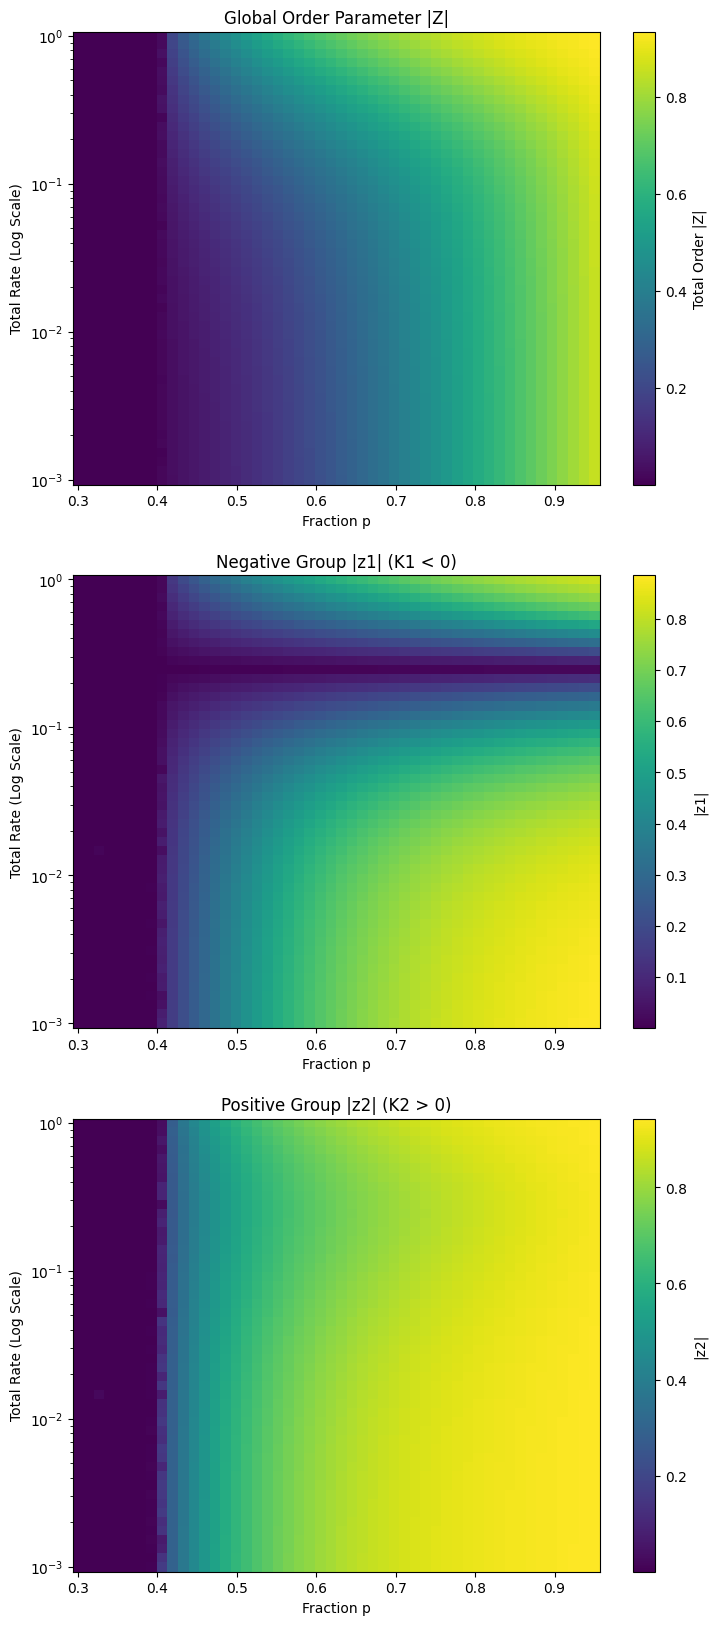

In [25]:
# 绘图部分修改：
plt.figure(figsize=(8.5, 20))

plt.subplot(3, 1, 1)
# 生成网格坐标 (注意：pcolormesh 需要网格坐标)
P_grid, Rate_grid = np.meshgrid(p_vals, rate_vals)
# 使用 pcolormesh
plt.pcolormesh(P_grid, Rate_grid, R_mat, shading='auto', cmap='viridis')
# 关键步骤：直接设置 Y 轴为 log
plt.yscale('log')
plt.colorbar(label='Total Order |Z|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate (Log Scale)')
plt.title('Global Order Parameter |Z|')

# 2. 负耦合组 |z1|
plt.subplot(3, 1, 2)
# 生成网格坐标 (注意：pcolormesh 需要网格坐标)
P_grid, Rate_grid = np.meshgrid(p_vals, rate_vals)
# 使用 pcolormesh
plt.pcolormesh(P_grid, Rate_grid, R1_mat, shading='auto', cmap='viridis')
# 关键步骤：直接设置 Y 轴为 log
plt.yscale('log')
plt.colorbar(label='|z1|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate (Log Scale)')
plt.title('Negative Group |z1| (K1 < 0)')

# 3. 正耦合组 |z2|
plt.subplot(3, 1, 3)
# 生成网格坐标 (注意：pcolormesh 需要网格坐标)
P_grid, Rate_grid = np.meshgrid(p_vals, rate_vals)
# 使用 pcolormesh
plt.pcolormesh(P_grid, Rate_grid, R2_mat, shading='auto', cmap='viridis')
# 关键步骤：直接设置 Y 轴为 log
plt.yscale('log')
plt.colorbar(label='|z2|')
plt.xlabel('Fraction p')
plt.ylabel('Total Rate (Log Scale)')
plt.title('Positive Group |z2| (K2 > 0)')

plt.show()